In [6]:
# import Agros Suite
from agrossuite import agros
from agrossuite.vtk_tools import view_geometry, view_scalar

import matplotlib.pylab as pl

In [7]:
# enable stdout
agros.options.log_stdout = False

# problem
problem = agros.problem(clear = True)
problem.coordinate_type = "planar"
problem.mesh_type = "triangle"

# parameters
problem.parameters["W"] = 0.1
problem.parameters["b"] = 0.4
problem.parameters["h"] = 0.05
problem.parameters["tg"] = 0.01
problem.parameters["ts"] = 0.01

# fields
# electrostatic
electrostatic = problem.field("electrostatic")
electrostatic.analysis_type = "steadystate"
electrostatic.matrix_solver = "external_plugin"
electrostatic.number_of_refinements = 1
electrostatic.polynomial_order = 2
electrostatic.adaptivity_type = "disabled"
electrostatic.solver = "linear"

# boundaries
electrostatic.add_boundary("Neumann", "electrostatic_surface_charge_density", {"electrostatic_surface_charge_density" : 0})
electrostatic.add_boundary("Voltage", "electrostatic_potential", {"electrostatic_potential" : 1})
electrostatic.add_boundary("Ground", "electrostatic_potential", {"electrostatic_potential" : 0})

# materials
electrostatic.add_material("Strip", {"electrostatic_charge_density" : 0, "electrostatic_permittivity" : 2.6})
electrostatic.add_material("Air", {"electrostatic_charge_density" : 0, "electrostatic_permittivity" : 1})

# magnetic
magnetic = problem.field("magnetic")
magnetic.analysis_type = "steadystate"
magnetic.matrix_solver = "external_plugin"
magnetic.number_of_refinements = 1
magnetic.polynomial_order = 2
magnetic.adaptivity_type = "disabled"
magnetic.solver = "linear"

# boundaries
magnetic.add_boundary("Neumann", "magnetic_surface_current", {"magnetic_surface_current_real" : 0})
magnetic.add_boundary("A = 0", "magnetic_potential", {"magnetic_potential_real" : 0})

# materials
magnetic.add_material("I+", {"magnetic_conductivity" : 0, "magnetic_current_density_external_real" : "0.5/(W/2*ts)", "magnetic_permeability" : 1, "magnetic_remanence" : 0, "magnetic_remanence_angle" : 0, "magnetic_velocity_angular" : 0, "magnetic_velocity_x" : 0, "magnetic_velocity_y" : 0})
magnetic.add_material("I-", {"magnetic_conductivity" : 0, "magnetic_current_density_external_real" : "-0.5/(b/2*tg)", "magnetic_permeability" : 1, "magnetic_remanence" : 0, "magnetic_remanence_angle" : 0, "magnetic_velocity_angular" : 0, "magnetic_velocity_x" : 0, "magnetic_velocity_y" : 0})
magnetic.add_material("Air", {"magnetic_conductivity" : 0, "magnetic_current_density_external_real" : 0, "magnetic_permeability" : 1, "magnetic_remanence" : 0, "magnetic_remanence_angle" : 0, "magnetic_velocity_angular" : 0, "magnetic_velocity_x" : 0, "magnetic_velocity_y" : 0})

# geometry
geometry = problem.geometry()
geometry.add_edge(0, 0.6, 0.6, 0.6, boundaries = {"magnetic" : "A = 0"})
geometry.add_edge(0.6, 0.6, 0.6, -0.6, boundaries = {"magnetic" : "A = 0"})
geometry.add_edge(0.6, -0.6, 0, -0.6, boundaries = {"magnetic" : "A = 0"})
geometry.add_edge(0, "-tg", 0, -0.6, boundaries = {"electrostatic" : "Neumann", "magnetic" : "Neumann"})
geometry.add_edge(0, 0, 0, "-tg", boundaries = {"electrostatic" : "Neumann", "magnetic" : "Neumann"})
geometry.add_edge(0, "-tg", "b/2", "-tg", boundaries = {"electrostatic" : "Ground"})
geometry.add_edge("b/2", "h", "b/2", 0)
geometry.add_edge("W/2", "h", 0, "h", boundaries = {"electrostatic" : "Voltage"})
geometry.add_edge(0, "h+ts", 0, "h", boundaries = {"electrostatic" : "Neumann", "magnetic" : "Neumann"})
geometry.add_edge(0, 0, 0, "h", boundaries = {"electrostatic" : "Neumann", "magnetic" : "Neumann"})
geometry.add_edge("W/2", "h+ts", "W/2", "h", boundaries = {"electrostatic" : "Voltage"})
geometry.add_edge(0, "h+ts", "W/2", "h+ts", boundaries = {"electrostatic" : "Voltage"})
geometry.add_edge("W/2", "h", "b/2", "h")
geometry.add_edge(0, 0.6, 0, "h+ts", boundaries = {"electrostatic" : "Neumann", "magnetic" : "Neumann"})
geometry.add_edge("b/2", 0, "b/2", "-tg", boundaries = {"electrostatic" : "Ground"})
geometry.add_edge("b/2", 0, 0, 0, boundaries = {"electrostatic" : "Ground"})

geometry.add_label(0.456863, 0.29972, materials = {"electrostatic" : "Air", "magnetic" : "Air"})
geometry.add_label("b/4", "h/2", materials = {"electrostatic" : "Strip", "magnetic" : "Air"})
geometry.add_label("W/4", "h+ts/2", materials = {"electrostatic" : "none", "magnetic" : "I+"})
geometry.add_label("b/4", "-tg/2", materials = {"electrostatic" : "none", "magnetic" : "I-"})

3

In [8]:
# recipes 
electrostatic.add_recipe_volume_integral("We", "electrostatic_energy", [0, 1], -1, -1)
magnetic.add_recipe_volume_integral("Wm", "magnetic_energy", [0, 1, 2, 3], -1, -1)

# studies
study_nlopt = problem.add_study("nlopt")
study_nlopt.add_parameter("W", 0.01, 0.05)
study_nlopt.add_parameter("b", 0.06, 0.3)
study_nlopt.add_parameter("h", 0.01, 0.1)
study_nlopt.add_parameter("tg", 0.001, 0.03)
study_nlopt.add_parameter("ts", 0.001, 0.03)
study_nlopt.add_functional("OF", "abs(sqrt((4*Wm/1**2)/(4*We/1**2))-75)", 100)
study_nlopt.add_functional("Z0", "sqrt((4*Wm/1**2)/(4*We/1**2))", 0)
study_nlopt.clear_solution = True
study_nlopt.solve_problem = True
study_nlopt.settings["xtol_rel"] = 1e-06
study_nlopt.settings["xtol_abs"] = 1e-12
study_nlopt.settings["ftol_rel"] = 1e-06
study_nlopt.settings["ftol_abs"] = 1e-12
study_nlopt.settings["n_iterations"] = 50
study_nlopt.settings["algorithm"] = "ln_bobyqa"

# computation
study_nlopt.solve()

Solver: output stream error
"Couldn't write json problem file ''."


In [9]:
of_z0 = study_nlopt.values("Z0")

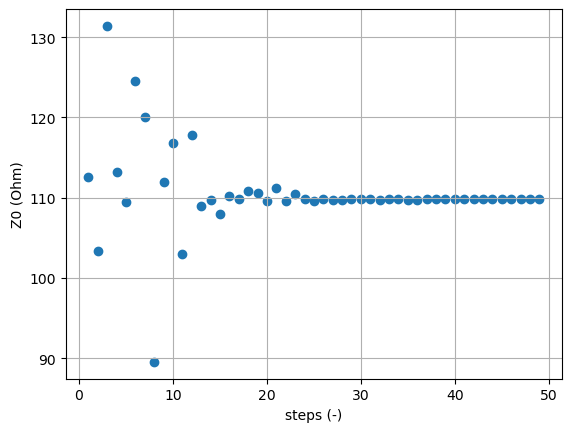

In [10]:
n = pl.linspace(1, len(of_z0), len(of_z0))

pl.scatter(n, of_z0)
pl.xlabel("steps (-)")
pl.ylabel("Z0 (Ohm)")
pl.grid(True)